# Embedding Matching

## Algorithm
1. choose anchor
    * (S) global randomly, target randomly
    * (S) dimension reduction + cluster on raw text embedding & select center
    * (U) Graph emb + cluster, match center
    * (U) umap + cluster, match center
2. alignment
    1. umap
        * aligned umap
        * umap + procrustes transformation, seperately
        * umap + mlp
    2. statistic
        * baseline
        * umap

### TODO
Exp:
1. different mimic doc emb
    * bert 1234
    * word emb avg
2. different select anchor appoarch
    * random
    * kmeans
    * gaussian mixture
3. mlp learn similarity
4. psuedo anchor
    * umap + hdbscan(center?)
        * problem: same cluster size

Survey:
1. representative data
2. embedding matching

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [2]:
import umap
import umap.plot

In [3]:
from scipy.spatial.distance import cdist
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist

In [4]:
from sklearn.datasets import fetch_20newsgroups
news_data = fetch_20newsgroups(subset='test')
n = len(news_data.data)

In [5]:
print(news_data.target.shape)
news_data.target
news_data.data[0]

(7532,)


'From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. GANDLER)\nSubject: Need info on 88-89 Bonneville\nOrganization: University at Buffalo\nLines: 10\nNews-Software: VAX/VMS VNEWS 1.41\nNntp-Posting-Host: ubvmsd.cc.buffalo.edu\n\n\n I am a little confused on all of the models of the 88-89 bonnevilles.\nI have heard of the LE SE LSE SSE SSEI. Could someone tell me the\ndifferences are far as features or performance. I am also curious to\nknow what the book value is for prefereably the 89 model. And how much\nless than book value can you usually get them for. In other words how\nmuch are they in demand this time of year. I have heard that the mid-spring\nearly summer is the best time to buy.\n\n\t\t\tNeil Gandler\n'

In [6]:
# https://www.sbert.net/docs/pretrained_models.html
main_model_type = 'all-mpnet-base-v1'
mimic_model_type = 'all-distilroberta-v1' 

# all-mpnet-base-v2
# all-distilroberta-v1
#'all-MiniLM-L12-v2' 
# average_word_embeddings_glove.6B.300d

from sentence_transformers import SentenceTransformer
main_model = SentenceTransformer(main_model_type)
mimic_model = SentenceTransformer(mimic_model_type)

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.85k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/591 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
main_emb = main_model.encode(news_data.data)
mimic_emb = mimic_model.encode(news_data.data)

## Select Anchor

In [8]:
select_num = 200

### global random k

In [9]:
anchor_index = np.random.choice(np.arange(n), size=select_num, replace=False)
match_index = np.delete(np.arange(n), anchor_index)

anchor_index, match_index

(array([7046, 1937, 7102, 1549, 5247, 3707, 1902, 1802, 3769, 7155, 1562,
         107, 3440,   79, 1176, 4797, 3727, 3124, 3112, 1353, 5963,  924,
        5728, 4571, 6541, 5883, 3835, 3717, 2988, 1566, 2212, 2267, 7237,
        4314, 6527,  605, 6753, 5954,  689, 5859, 3973, 1563, 7269, 4688,
        7187, 1423, 7486, 1372, 2169, 7181, 5703, 5680, 2321, 6972, 4141,
        3416,  156, 4942,  732, 6815,  255, 6227, 2525, 1879, 1568, 3391,
        2243, 2926, 6574, 4876,  886, 2870, 4754, 6346,  988, 5746, 2144,
        2462, 4213, 6737, 2998, 2495, 7240, 4591, 6679, 1959, 3961, 6777,
        7063, 4052, 6453, 2717, 6375, 5339, 4533, 1841, 2348,  873, 4078,
         538, 5040, 2967, 4584,  845, 4342, 2307, 4411, 4440, 1102, 5019,
        5876, 2148, 5783,  375, 5352, 4434,  167, 7430, 6884, 5094, 2872,
          19, 4188, 5907, 5088, 1374,  646, 5336, 4401, 5239, 2541, 5793,
        6093, 2760, 5623, 7132, 6450, 4748,  321, 4373, 3556,  916, 6790,
        1968, 5269, 4198,  212, 3937, 

### cluster center
check https://scikit-learn.org/stable/modules/clustering.html

In [10]:
mimic_emb_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', random_state=33).fit_transform(mimic_emb)

#### KMeans

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=select_num, random_state=0).fit(mimic_emb_umap)
kmeans.cluster_centers_

dm = cdist(kmeans.cluster_centers_, mimic_emb_umap, 'euclidean')
anchor_index = np.argmin(dm, axis=1)
match_index = np.delete(np.arange(n), anchor_index)

anchor_index, match_index

(array([1420, 1451, 1445, 3490, 4993, 5199,  772, 2274, 1308, 1785, 6749,
        5447, 7336, 4397, 7453, 6931, 7154, 6814, 5657, 4872,  333,  925,
         908,  863, 4232, 1010, 3575, 6949, 1902, 7502, 5055, 3180, 3227,
        5952, 6145, 6746, 6573, 6938,  577, 6740, 4862, 3442, 6646, 7481,
        1464, 1489, 3300, 4457,  133,   52, 7318, 1625, 7221,  566, 5511,
        1211, 6689, 3293, 4627, 6544,  555, 6751, 5707, 1945, 4960, 5718,
        3122, 3446, 1599, 2351, 5501, 2878, 6395,  727, 2806, 2666, 3630,
         423, 2428, 3387,  747, 3243,  452, 6244, 1684, 3718, 2411, 7003,
        3648, 6336, 3610,  289, 2780, 6074, 5046,  748, 3173, 6293, 2762,
        6061, 1701, 4642, 5695, 7463, 1364, 2609, 2549, 7479, 2417, 1499,
         851,  280, 6510, 7267, 5681,  866, 3809, 3625, 2744, 5414,  977,
        3914, 6865,  636, 1825, 3971, 3894, 2198,   32, 3818, 7509, 2064,
        2081, 3189, 1395, 7020, 1001, 6730,  672, 6033, 3105, 5135, 2148,
        3529, 7379, 1152, 6221,  572, 

#### GaussianMixture

In [12]:
from sklearn.mixture import GaussianMixture

clustering = GaussianMixture(n_components=select_num).fit(mimic_emb_umap)

dm = cdist(clustering.means_, mimic_emb_umap, 'euclidean')
anchor_index = np.argmin(dm, axis=1)
match_index = np.delete(np.arange(n), anchor_index)

anchor_index, match_index

(array([2324, 3870, 4672,  795, 4188, 1001, 2932, 6425, 5226, 3732, 3036,
        2097, 3625, 6650,  431,  405, 5012, 5458,  851, 4407, 2383, 3243,
        4119, 1670, 6746,   14, 4602, 1182, 5758, 1902, 5273, 3754, 5343,
        6938, 5725, 6926, 6250, 6169, 4646,  494, 5471, 2630, 3510, 2826,
        7318, 5235, 2511, 6818,  910, 1464, 2536, 2115, 5707, 1595, 3840,
        4492, 5511, 2295, 2422, 6600, 3607, 6111,  568, 1484, 4259, 6646,
        7379, 3064, 3156, 4159, 2132, 4014, 7521, 7222, 3899, 5476, 4715,
        4409, 3275, 2762, 5570, 7361,  555, 1492, 1931,  170, 5718, 3698,
        1583, 6765, 5743, 5952, 5545, 2609,  727,  858,  672, 7237, 1078,
         289, 7091, 6413,  284, 7153, 7042, 3040,   21, 3078, 4416, 2198,
        6464,  794, 1744,  720, 2173, 1582,   32, 4289, 2676, 4252, 3914,
        6719, 5104, 3165, 4049, 5496, 5772,  781, 4487,  886,  420,  155,
        6917, 6510, 5650, 7376, 6730, 6933, 1031, 6504, 6755,  816, 7514,
          84, 6857, 6570, 1193, 6949, 

#### HDBSCAN not good

In [13]:
# import hdbscan

# clusterer = hdbscan.HDBSCAN(min_cluster_size=select_num, min_samples=1000)
# clusterer.fit(mimic_emb_umap)
# clusterer.probabilities_

In [14]:
# plt.hist(clusterer.probabilities_)

In [15]:
# (clusterer.probabilities_ == 1).sum()

In [16]:
# from sklearn.cluster import DBSCAN

# clustering = DBSCAN(eps=0.5, min_samples=5).fit(mimic_emb_umap)
# print(len(clustering.core_sample_indices_))
# anchor_index = clustering.core_sample_indices_
# match_index = np.delete(np.arange(n), anchor_index)

# anchor_index, match_index

## AlignedUMAP

https://umap-learn.readthedocs.io/en/latest/aligned_umap_basic_usage.html

It may happen that it would be beneficial to have different UMAP embeddings aligned with each other. There are several ways to go about doing this. One simple approach is to simply embed each dataset with UMAP independently and then solve for a Procrustes transformation on shared points. An alternative approach is to embed the first dataset and then construct an initial embedding for the second dataset based on locations of shared points in the first embedding and then go from there. A third approach, which will provide better alignments in general, is to optimize both embeddings at the same time with some form of constraint as to how far shared points can take different locations in different embeddings during the optimization. 

> AlignedUMAP is the third one

### Distance
1. Minkowski style metrics
    * euclidean
    * manhattan
    * chebyshev
    * minkowski
2. Miscellaneous spatial metrics
    * canberra
    * braycurtis
    * haversine
3. Normalized spatial metrics
    * mahalanobis
    * wminkowski
    * seuclidean
4. Angular and correlation metrics
    * cosine
    * correlation

In [17]:
relation_dict = {idx: idx for idx in anchor_index}
n_neighbors = 15
min_dist = 0.1
n_components = 2
metric = 'euclidean'

alignment_window_size = 2
alignment_regularisation = 10

In [18]:
aligned_mapper = umap.AlignedUMAP(n_neighbors=n_neighbors,
                                  min_dist=min_dist,
                                  n_components=n_components,
                                  metric=metric,
                                  alignment_window_size=alignment_window_size, \
                                  alignment_regularisation=alignment_regularisation).fit([main_emb, mimic_emb], relations=[relation_dict])

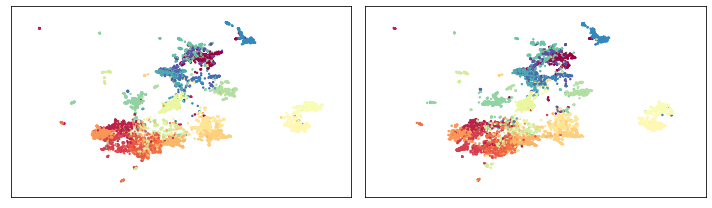

In [19]:
# plot if n_components(dim) == 2
def axis_bounds(embedding):
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

if n_components == 2:
    fig, axs = plt.subplots(1,2, figsize=(10, 3))
    ax_bound = axis_bounds(np.vstack(aligned_mapper.embeddings_))
    for i, ax in enumerate(axs.flatten()):
        current_target = news_data.target
        ax.scatter(*aligned_mapper.embeddings_[i].T, s=2, c=current_target, cmap="Spectral")
        ax.axis(ax_bound)
        ax.set(xticks=[], yticks=[])
    plt.tight_layout()

In [20]:
main_emb_umap = aligned_mapper.embeddings_[0]
mimic_emb_umap = aligned_mapper.embeddings_[1]

### Match: Directly match by closest point

In [21]:
main_emb_umap_match = main_emb_umap[match_index]
mimic_emb_umap_match = mimic_emb_umap[match_index]

dm = cdist(main_emb_umap_match, mimic_emb_umap_match, 'euclidean')
# euclidean, seuclidean, cosine, correlation, chebyshev
match_idx = np.argmin(dm, axis=1)

In [22]:
def calculate_metrics(match_index_prediction, match_main_emb, verbose=True):
    # evaluation metric
    # 1. accuracy
    ground_truth = np.arange(len(match_index_prediction))
    accuracy = np.mean(ground_truth == match_index_prediction)

    # 2. average origin doc emb cosine similarity
    predict_main_emb = match_main_emb[match_index_prediction]
    cos_pred_match = cosine_similarity(predict_main_emb, match_main_emb)

    average_cos = np.trace(cos_pred_match) / match_main_emb.shape[0]

    if verbose:
        print('len', len(match_index_prediction))
        print('accuracy', accuracy)
        print('global average cos similarity', np.mean(cos_pred_match))
        print('predict average cos similarity', average_cos)
    
    return accuracy, average_cos

In [23]:
calculate_metrics(match_idx, main_emb[match_index])

len 7332
accuracy 0.02182214948172395
global average cos similarity 0.09728798
predict average cos similarity 0.3906890319724325


(0.02182214948172395, 0.3906890319724325)

### Match: anchor match baseline

In [24]:
def anchor_matching(main_emb, mimic_emb, emb_for_cos):    
    # find embeddings
    anchor_main_emb = main_emb[anchor_index]
    anchor_mimic_emb = mimic_emb[anchor_index]
    match_main_emb = main_emb[match_index]
    match_mimic_emb = mimic_emb[match_index]
    
    # calculate distance
    distance = euclidean_distances
    main_am_cos = distance(anchor_main_emb, match_main_emb)
    mimic_am_cos = distance(anchor_mimic_emb, match_mimic_emb)
    
    # calculate distance rank
    main_am_cos_rank = np.argsort(np.argsort(main_am_cos))
    mimic_am_cos_rank = np.argsort(np.argsort(mimic_am_cos))

    main_am_cos_min_anchor_idx = np.argmin(main_am_cos_rank, axis=0)
    main_am_cos_min_anchor_rank = np.min(main_am_cos_rank, axis=0)

    # match_main_emb -> match_main_data
    from numpy import linalg as LA
    match_index_prediction = []
    if single_anchor_point:
        for i in range(match_main_emb.shape[0]):
            min_anchor_idx = main_am_cos_min_anchor_idx[i]
            min_anchor_rank = main_am_cos_min_anchor_rank[i]
            index_prediction = np.where(mimic_am_cos_rank[min_anchor_idx] == min_anchor_rank)[0][0]

            match_index_prediction.append(index_prediction)
    else:
        for i in tqdm(range(match_main_emb.shape[0])):
            cos = main_am_cos[:, i].reshape(-1, 1)
            cos_diff = LA.norm(mimic_am_cos - cos, axis=0, ord=2)
            cos_diff = (abs(mimic_am_cos - cos) / cos).sum(axis=0)
            pred_idx = np.argmin(cos_diff)
            match_index_prediction.append(pred_idx)

    match_index_prediction = np.array(match_index_prediction)

    accuracy, average_cos = calculate_metrics(match_index_prediction, emb_for_cos[match_index])
    
    return accuracy, average_cos

In [25]:
single_anchor_point = True

In [26]:
anchor_matching(main_emb, mimic_emb, main_emb)

len 7332
accuracy 0.04896344789961811
global average cos similarity 0.11000923
predict average cos similarity 0.39219283433280483


(0.04896344789961811, 0.39219283433280483)

In [27]:
anchor_matching(main_emb_umap, mimic_emb_umap, main_emb)

len 7332
accuracy 0.017866884888161485
global average cos similarity 0.098270014
predict average cos similarity 0.38148198021089064


(0.017866884888161485, 0.38148198021089064)

In [28]:
single_anchor_point = False

In [29]:
anchor_matching(main_emb, mimic_emb, main_emb)

  0%|          | 0/7332 [00:00<?, ?it/s]

len 7332
accuracy 0.2673213311511184
global average cos similarity 0.08643282
predict average cos similarity 0.6332974514542417


(0.2673213311511184, 0.6332974514542417)

In [30]:
anchor_matching(main_emb_umap, mimic_emb_umap, main_emb)

  0%|          | 0/7332 [00:00<?, ?it/s]

len 7332
accuracy 0.022776868521549372
global average cos similarity 0.097157784
predict average cos similarity 0.3931551453069592


(0.022776868521549372, 0.3931551453069592)

## Embedding Transformation Learning

In [31]:
anchor_index = np.random.choice(np.arange(n), size=select_num, replace=False)
match_index = np.delete(np.arange(n), anchor_index)

anchor_index, match_index

(array([4800, 5064, 5155, 7231, 3961,  512, 1560, 7183, 2353, 6492,  607,
        4492, 1287, 1937, 5227, 2112, 2263, 2427, 6273,  805, 4247, 3666,
        2387, 2032, 2004, 3937, 2393, 4413, 1768,  965, 5160, 4648, 3705,
        1823,   90, 7425, 6251, 1074, 1081, 2746, 1292, 3002, 3805, 5369,
        3393, 6954, 6837,  845, 3069, 5413, 6373, 5514, 2278, 6842, 1124,
        7492,  185, 5073, 6179, 2818, 1093,  242, 6297, 2077, 6358, 2563,
        2806, 2169,  337, 4378, 4745, 6420, 2165, 3635, 4043, 3562, 1019,
         109, 5101, 6697, 5707, 6489, 5593, 4930, 2628, 3899, 1822, 3610,
        4098, 2195, 1508, 5230, 6268,  255, 5586, 2322, 6701, 1908, 5639,
        2398, 2636, 2614, 6459, 1530, 5066, 6593, 5354, 5327, 6794, 6646,
        6067, 1455, 4990, 3545, 6231, 1043, 7485, 4591, 6675,   53, 3358,
         386, 1337, 2576, 5023, 6862, 5213, 3432, 3521,  870, 4732, 2837,
        2282, 5949, 6011, 4534, 6130, 1621, 4850, 2835, 5493, 5899,  523,
        5339,  705,  794, 1226, 5380, 

In [32]:
train_main_emb = main_emb[anchor_index]
valid_main_emb = main_emb[match_index]

train_mimic_emb = mimic_emb[anchor_index]
valid_mimic_emb = mimic_emb[match_index]

## MLP baseline

In [33]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, activation='relu', max_iter=500, tol=1e-4).fit(train_main_emb, train_mimic_emb)
pred_main_emb = regr.predict(valid_main_emb)

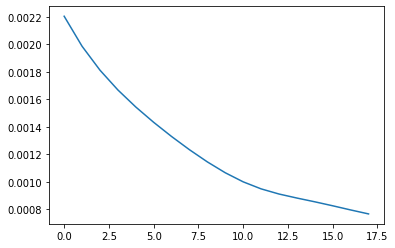

In [34]:
plt.plot(regr.loss_curve_)

In [35]:
dm = cdist(pred_main_emb, valid_mimic_emb, 'euclidean')
# euclidean, seuclidean, cosine, correlation, chebyshev
match_idx = np.argmin(dm, axis=1)

In [36]:
calculate_metrics(match_idx, main_emb[match_index])

len 7332
accuracy 0.0006819421713038735
global average cos similarity 0.16678466
predict average cos similarity 0.23241053704544293


(0.0006819421713038735, 0.23241053704544293)

## Procrustes baseline

In [37]:
from procrustes.orthogonal import orthogonal
from procrustes.generic import generic
from procrustes.rotational import rotational
from procrustes.orthogonal import orthogonal_2sided

def procrustes_train(model):
    print('train num', train_main_emb.shape[0])
    if model == 'orthogonal':
        result = orthogonal(train_main_emb, train_mimic_emb, translate=translate, scale=scale)
    elif model == 'generic':
        result = generic(train_main_emb, train_mimic_emb, translate=translate, scale=scale)
    elif model == 'rotational':
        result = rotational(train_main_emb, train_mimic_emb, translate=translate, scale=scale)
    elif model == 'orthogonal_2sided':
        result = orthogonal_2sided(train_main_emb, train_mimic_emb, translate=translate, scale=scale, single=False)
    
    pred_main_emb = valid_main_emb@result.t
    dm = cdist(pred_main_emb, valid_mimic_emb, 'euclidean')
    match_idx = np.argmin(dm, axis=1)
    
    acc, cos = calculate_metrics(match_idx, valid_main_emb)
    
model = 'rotational'
translate = True
scale = False
procrustes_train(model)

train num 200
len 7332
accuracy 0.5931533006001091
global average cos similarity 0.10431941
predict average cos similarity 0.8553483445853791


### MultiLabel Linear Regression

In [38]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, ARDRegression, MultiTaskLasso, ElasticNet

model = MultiOutputRegressor(LinearRegression()).fit(train_main_emb, train_mimic_emb)
# model = MultiOutputRegressor(Lasso(alpha=0.1)).fit(train_main_emb, train_mimic_emb)
# model = MultiOutputRegressor(ElasticNet()).fit(train_main_emb, train_mimic_emb)
# model = MultiTaskLasso(alpha=0.0001).fit(train_main_emb, train_mimic_emb)
# model = MultiOutputRegressor(AdaBoostRegressor()).fit(train_main_emb, train_mimic_emb)

pred_main_emb = model.predict(valid_main_emb)

dm = cdist(pred_main_emb, valid_mimic_emb, 'euclidean')
match_idx = np.argmin(dm, axis=1)

acc, cos = calculate_metrics(match_idx, valid_main_emb)

len 7332
accuracy 0.48022367703218766
global average cos similarity 0.11169329
predict average cos similarity 0.7786809959765412


### Grid search select num

In [39]:
mlp_result = {}
p1_result = {}
p2_result = {}

for select_num in [20, 40, 100, 200, 400, 1000, 2000, 3000]:
    print(select_num)
    anchor_index = np.random.choice(np.arange(n), size=select_num, replace=False)
    match_index = np.delete(np.arange(n), anchor_index)

    train_main_emb = main_emb[anchor_index]
    valid_main_emb = main_emb[match_index]

    train_mimic_emb = mimic_emb[anchor_index]
    valid_mimic_emb = mimic_emb[match_index]

    regr = MLPRegressor(random_state=1, max_iter=500).fit(train_main_emb, train_mimic_emb)
    pred_main_emb = regr.predict(valid_main_emb)
    dm = cdist(pred_main_emb, valid_mimic_emb, 'euclidean')
    match_idx = np.argmin(dm, axis=1)
    acc, cos = calculate_metrics(match_idx, main_emb[match_index])
    
    mlp_result[select_num] = acc, cos
    
    result = orthogonal(train_main_emb, train_mimic_emb, translate=True, scale=False)
    pred_main_emb = valid_main_emb@result.t
    dm = cdist(pred_main_emb, valid_mimic_emb, 'euclidean')
    match_idx = np.argmin(dm, axis=1)
    acc, cos = calculate_metrics(match_idx, valid_mimic_emb)
    
    p1_result[select_num] = acc, cos
    
    result = generic(train_main_emb, train_mimic_emb, translate=True, scale=False)
    pred_main_emb = valid_main_emb@result.t
    dm = cdist(pred_main_emb, valid_mimic_emb, 'euclidean')
    match_idx = np.argmin(dm, axis=1)
    acc, cos = calculate_metrics(match_idx, valid_mimic_emb)
    
    p2_result[select_num] = acc, cos

20
len 7512
accuracy 0.0005324813631522897
global average cos similarity 0.1695838
predict average cos similarity 0.1961210045697717
len 7512
accuracy 0.00718849840255591
global average cos similarity 0.1660446
predict average cos similarity 0.33031596060885915
len 7512
accuracy 0.00825346112886049
global average cos similarity 0.17298834
predict average cos similarity 0.34135012885632987
40
len 7492
accuracy 0.000800854244527496
global average cos similarity 0.16825566
predict average cos similarity 0.21022814960958355
len 7492
accuracy 0.04311265349706354
global average cos similarity 0.15740375
predict average cos similarity 0.41486834003145023
len 7492
accuracy 0.05726107848371596
global average cos similarity 0.16113244
predict average cos similarity 0.4339713663324212
100
len 7432
accuracy 0.00026910656620021526
global average cos similarity 0.16403507
predict average cos similarity 0.23492428355632736
len 7432
accuracy 0.25995694294940797
global average cos similarity 0.15502246

In [40]:
cols = ['accuracy', 'average cos']
mlp_df = pd.DataFrame(mlp_result).T
mlp_df.columns = cols
p1_df = pd.DataFrame(p1_result).T
p1_df.columns = cols
p2_df = pd.DataFrame(p2_result).T
p2_df.columns = cols

In [41]:
res = pd.concat([mlp_df, p1_df, p2_df], axis=1)

arrays = [['mlp', 'mlp', 'orthogonal procrustes', 'orthogonal procrustes', 'generic procrustes', 'generic procrustes'], res.columns]
new_cols = pd.MultiIndex.from_arrays(arrays, names=('model', ''))

res.columns = new_cols
res

model       mlp             orthogonal procrustes              \
       accuracy average cos              accuracy average cos   
20     0.000532    0.196121              0.007188    0.330316   
40     0.000801    0.210228              0.043113    0.414868   
100    0.000269    0.234924              0.259957    0.637985   
200    0.000682    0.241328              0.546781    0.829848   
400    0.000421    0.245471              0.784492    0.942134   
1000   0.004746    0.341692              0.881660    0.974512   
2000   0.043926    0.444093              0.909617    0.980872   
3000   0.118049    0.523688              0.926081    0.984340   

model generic procrustes              
                accuracy average cos  
20              0.008253    0.341350  
40              0.057261    0.433971  
100             0.267761    0.644987  
200             0.500409    0.797629  
400             0.646943    0.872408  
1000            0.783680    0.935740  
2000            0.890456    0.976065  
3000            0.908870    0.981208

## Plot Umap Result
simple 20news umap result

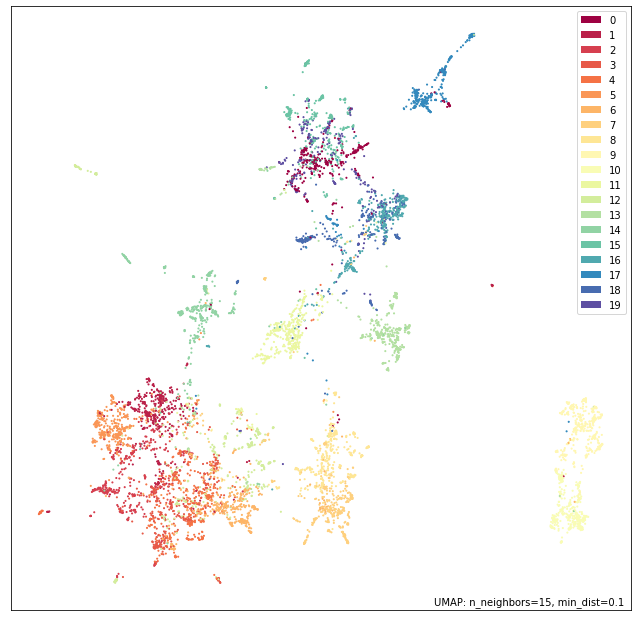

In [42]:
# https://umap-learn.readthedocs.io/en/latest/parameters.html
# https://umap-learn.readthedocs.io/en/latest/document_embedding.html
main_emb_plot = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', random_state=33).fit(main_emb)
f = umap.plot.points(main_emb_plot, labels=news_data.target)